# Imports and Functions

In [1]:
import sys
import os
import PyPDF2
from openai import OpenAI

sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from graph import build_rag_graph

In [2]:
def pdf_to_string(path):
    text = ""
    with open(path, 'rb') as pdf_file:
        reader = PyPDF2.PdfReader(pdf_file)
        for page in reader.pages:
            text += page.extract_text() + "\n"
    return text

# Multi-agent in-context RAG

## KB definition

In [3]:
# Here, I'm extracting the KB from a PDF file, but you can read it from an S3 bucket, for example

KB = pdf_to_string('../data/1q25-earnings-transcript.pdf')

In [4]:
print(KB[:600])

   
 
1Q25 FINANCIAL RESULTS 
EARNINGS CALL TRANSCRIPT 
April 11, 2025  
 
 
 
 
 
 
 
 
 NOVEMBER 2024  
 
 
  
 
 
 
  1 
MANAGEMENT DISCUSSION SECTION 
........................................................................................................................................................................................................................................................................................ 
Operator : Good morning, ladies and gentlemen. Welcome to JPMorganChase's First-Quarter 2025 Earnings Call. This call is being recorded. 
Your line will be muted f


## Compiling the multiagent graph

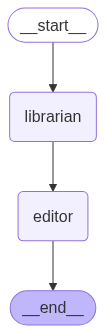

In [5]:
rag_graph = build_rag_graph()
rag_graph

## Inference using the multiagents

In [6]:
# Let's try to use GPT to ask about JPMorgan's results of first quarter of 2025

client = OpenAI(api_key=os.getenv('OPENAI_KEY'))

def chat_completion(prompt, system_message="You are a helpful assistant.", model="gpt-4-1106-preview"):
    response = client.chat.completions.create(
        model="gpt-4.1-nano-2025-04-14",
        messages=[
            {"role": "system", "content": system_message},
            {"role": "user", "content": prompt}
        ],
        temperature=0
    )
    return response.choices[0].message.content.strip()

prompt = "What is JPMorgan's revenue for first quarter 2025?"

chat_completion(prompt)

"I'm sorry, but I don't have information on JPMorgan's revenue for the first quarter of 2025. For the most recent and accurate financial data, please refer to JPMorgan's official earnings reports or their investor relations website."

Notice that GPT can't answer the question because it doesn't have the information!

Let's try with our multi-agentic RAG!

In [7]:
question = "What is JPMorgan's revenue for first quarter 2025?"

# Passing the question and the KB as state to the graph
state = {
    "question": question,
    "kb": KB
}

output = rag_graph.invoke(state)

print(output['answer'])

JPMorgan's revenue for the first quarter of 2025 is reported to be $46 billion.


Cool!! Now, the multiagents were able to search for chunks on the knowledge base and write a correct response!!

Let's try other questions.

In [8]:
question = "Did JPMorgan's expenses grew for first quarter 2025? If yes, how much?"

# Passing the question and the KB as state to the graph
state = {
    "question": question,
    "kb": KB
}

output = rag_graph.invoke(state)

print(output['answer'])

Yes, JPMorgan's expenses grew in the first quarter of 2025. The expenses increased by $840 million, which represents a 4% rise compared to the previous period.


In [9]:
question = "Did JPMorgan's securities services grew for first quarter 2025? If yes, how much?"

# Passing the question and the KB as state to the graph
state = {
    "question": question,
    "kb": KB
}

output = rag_graph.invoke(state)

print(output['answer'])

Yes, JPMorgan's Securities Services experienced growth in the first quarter of 2025. Specifically, the revenue from Securities Services increased by 7% year-on-year, driven by fee growth and higher deposit balances, although this was partially offset by deposit margin compression.


Answered correctly all the questions!